#Exploratory Data Analysis (EDA)

## Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels as sm

In [47]:
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import ks_2samp

In [19]:
import ipykernel
ipykernel.version_info

(6, 17, 1)

## Data Load and Feature Computation

In [20]:
time_df = yf.download('MSFT', start="2025-01-01", auto_adjust=True)
time_df.columns = [col[0] for col in time_df.columns]
time_df.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,415.514832,422.950005,411.812165,422.413951,16896500
2025-01-03,420.249939,420.924952,416.467841,417.996542,16662900
2025-01-06,424.716949,431.139572,422.364309,424.865845,20573600
2025-01-07,419.277100,427.496466,417.718589,425.858555,18139100
2025-01-08,421.451050,423.843406,418.453175,420.359099,15054600


In [21]:
time_df['Return'] = time_df['Close'].pct_change()
time_df['LogReturn'] = np.log(time_df['Close'] / time_df['Close'].shift(1))
time_df.describe()

,Close,High,Low,Open,Volume,Return,LogReturn
count,271.000000,271.000000,271.000000,271.000000,2.710000e+02,270.000000,270.000000
mean,462.847292,466.736060,458.628340,462.850830,2.315331e+07,0.000204,0.000069
std,49.243133,49.135344,49.848359,49.854927,1.092614e+07,0.016453,0.016450
min,352.669403,362.536482,342.951498,349.009021,5.855900e+06,-0.099931,-0.105284
25%,419.763519,423.396705,415.837470,420.632087,1.671695e+07,-0.007361,-0.007388
50%,477.460022,480.720001,472.796389,476.533265,2.080730e+07,0.000609,0.000609
75%,505.938065,509.307954,501.995454,505.328366,2.545680e+07,0.006294,0.006274
max,541.057373,553.502444,539.759814,553.283183,1.288553e+08,0.101337,0.096525


## General Data Exploration

### date gap diagnostics

In [22]:
time_df.index.diff().value_counts().head()

,count
Date,
1 days,208
3 days,50
4 days,7
2 days,5


In [23]:
# df for gap vs jump relation
analysis_df = time_df.copy()
analysis_df['GapDays'] = analysis_df.index.to_series().diff().dt.days
analysis_df['AbsJumpInClose'] = analysis_df['Close'].diff().abs()
analysis_df = analysis_df.dropna()

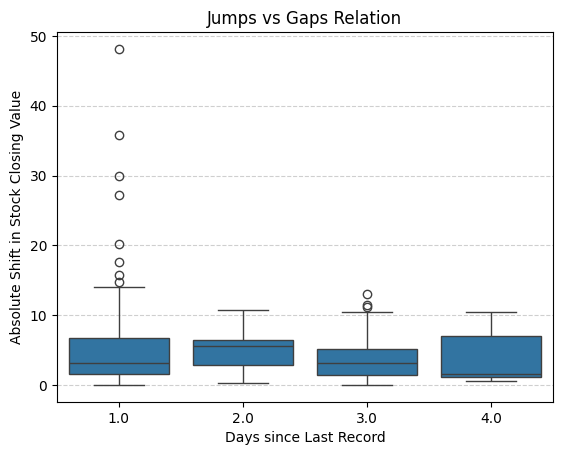

In [24]:
sns.boxplot(data=analysis_df, x = 'GapDays', y = 'AbsJumpInClose')
plt.title('Jumps vs Gaps Relation')
plt.xlabel('Days since Last Record')
plt.ylabel('Absolute Shift in Stock Closing Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [25]:
analysis_df.groupby('GapDays')['AbsJumpInClose'].describe()

,count,mean,std,min,25%,50%,75%,max
GapDays,,,,,,,,
1.0,208.0,4.989437,5.818645,0.019958,1.597702,3.204987,6.684105,48.130005
2.0,5.0,5.179791,3.918209,0.309998,2.830017,5.568939,6.510010,10.679993
3.0,50.0,3.939966,3.389847,0.010010,1.499733,3.109146,5.098480,13.079865
4.0,7.0,4.119629,4.062471,0.526123,1.158615,1.567078,6.976898,10.473175


* The longer gaps (more than 1 day) doesn't affect the jumps, suggesting no abnormality in stock data.

* The consecutive days have higher volatility and are more concerning.

### distribution

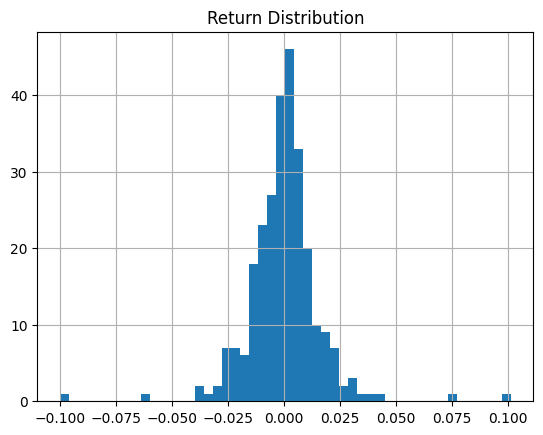

In [26]:
time_df["Return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()

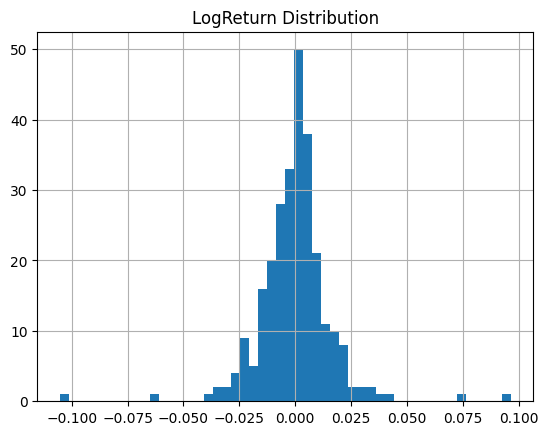

In [27]:
time_df["LogReturn"].hist(bins=50)
plt.title("LogReturn Distribution")
plt.show()

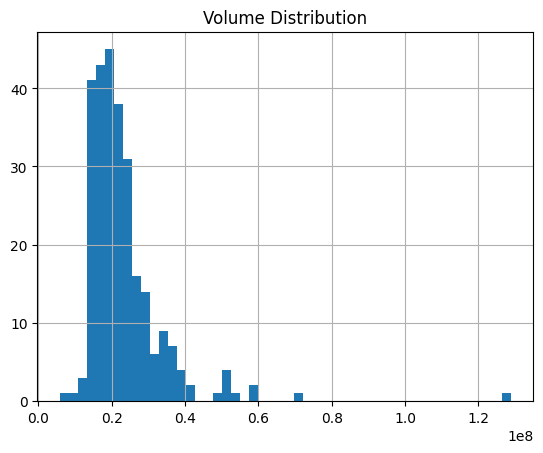

In [28]:
time_df['Volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.show()

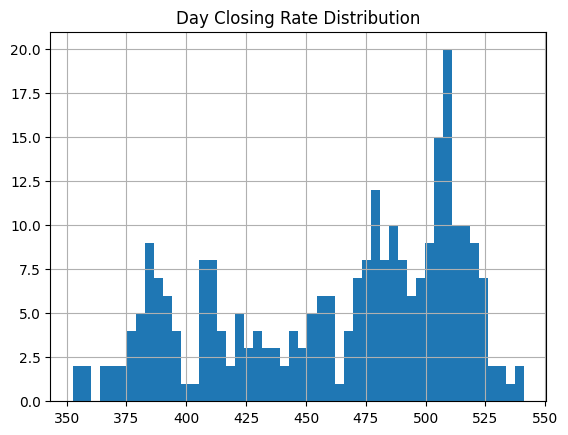

In [29]:
time_df['Close'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

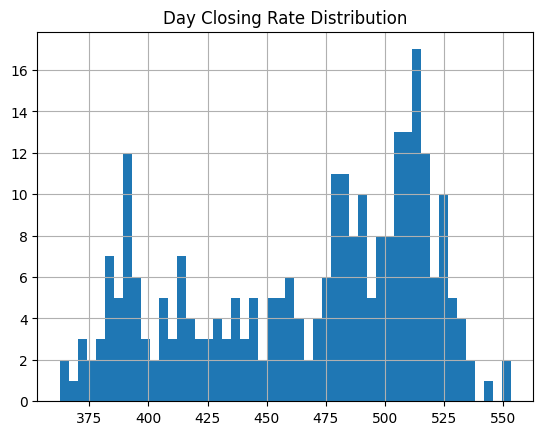

In [30]:
time_df['High'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

* Stock open and close price show multimodal distribution.
  * Tree-based (XGBoost, Random Forest) and Hidden Markov Model might work better than ARIMA or LSTM that work on sequencial data.
  * Feature Engineering may benefit in sequencial based models
* Return and log of retun show normal distribution.
* Volume shows positively skewed distribution

## Exploration Relevant to Forecast

### Stationarity Check

In [44]:
# weak stationary test
## augmented dickey fuller - diff based
## null hypothesis; non-stationary (series has root unit)
adf_close = adfuller(time_df['Close'])
adf_rtn = adfuller(time_df['Return'].dropna())

print("Close p-value:", adf_close[1])
print("Return p-value:", adf_rtn[1])

print("\nClose adf stat:", adf_close[0])
print("Return adf stat:", adf_rtn[0])

print('\nCritical Values for Close:')
for key, value in adf_close[4].items():
  print(f'{key}: {round(value, 3)}', end="\t")

print('\nCritical Values for Return:')
for key, value in adf_rtn[4].items():
  print(f'{key}: {round(value, 3)}', end="\t")

Close p-value: 0.6480874063158499
Return p-value: 7.140243684218319e-15

Close adf stat: -1.2581665028320366
Return adf stat: -8.985005200843844

Critical Values for Close:
1%: -3.455	5%: -2.872	10%: -2.573	
Critical Values for Return:
1%: -3.455	5%: -2.872	10%: -2.573	

In [46]:
# weak stationary test
## kpss test
## null hypothesis: stationary series
kpss_close = kpss(time_df['Close'], 'ct')
kpss_rtn = kpss(time_df['Return'].dropna(), 'ct')

print("Close p-value:", kpss_close[1])
print("Return p-value:", kpss_rtn[1])

print("\nClose adf stat:", kpss_close[0])
print("Return adf stat:", kpss_rtn[0])

print('\nCritical Values for Close:')
for key, value in kpss_close[3].items():
  print(f'{key}: {round(value, 3)}', end="\t")

print('\nCritical Values for Return:')
for key, value in kpss_rtn[3].items():
  print(f'{key}: {round(value, 3)}', end="\t")

Close p-value: 0.01
Return p-value: 0.04306344298402175

Close adf stat: 0.4079799441093709
Return adf stat: 0.1543238684191739

Critical Values for Close:
10%: 0.119	5%: 0.146	2.5%: 0.176	1%: 0.216	
Critical Values for Return:
10%: 0.119	5%: 0.146	2.5%: 0.176	1%: 0.216	

/tmp/ipython-input-1262517936.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_close = kpss(time_df['Close'], 'ct')


* Close is non stationary in both ADF (p>0.05) and KPSS (p<0.05) test.
* Return can be almost stationary, as ADF suggest stationary (p and criteria < limit) but KPSS reject null hypothesis (p<0.05 & criteria is in-between values)

In [53]:
time_df['Return'].drop[0:split]

,Return
Date,
2025-01-02,NaN
2025-01-03,0.011396
2025-01-06,0.010629
2025-01-07,-0.012808
2025-01-08,0.005185
...,...
2025-07-14,-0.000596
2025-07-15,0.005566
2025-07-16,-0.000395


In [59]:
# strict stationary test on return
## ks test
## null hyphothesis: stationary
split = len(time_df['Return'].dropna()) // 2
stat, pvalue = ks_2samp(time_df['Return'].dropna()[0:split],
                        time_df['Return'].dropna()[split:-1])
print(round(pvalue, 3))

0.627


In [60]:
split = len(time_df['Close'].dropna()) // 2
stat, pvalue = ks_2samp(time_df['Close'].dropna()[0:split],
                        time_df['Close'].dropna()[split:-1])
print(round(pvalue, 3))

0.0


* Return is strict stationary, and Close is not stationary.